In [31]:
import os

# Define the path for the extraction directory
extraction_directory = 'jaffe_dataset/jaffedbasee'  # Assuming you have already extracted the dataset

# Emotion codes and their corresponding directories
emotion_classes = {
    'HA': 'happy',
    'AN': 'angry',
    'SU': 'surprise',
    'NE': 'neutral',
    'SA': 'sad',
    'DI': 'disgust',
    'FE': 'fear'
}

# Confirm the organization
for emotion, emotion_label in emotion_classes.items():
    emotion_path = os.path.join(extraction_directory, emotion_label)
    image_count = len(os.listdir(emotion_path))
    print(f"{emotion_label}: {image_count} images")


happy: 31 images
angry: 30 images
surprise: 30 images
neutral: 30 images
sad: 31 images
disgust: 29 images
fear: 32 images


In [30]:
import shutil

# Define the destination directory on your local machine
save_directory = 'Jafeedatabsefolder'     # creat the folder of the same name mention here in machine it will create allsubfolders

# Create directories for each emotion class if they don't exist
for emotion_label in emotion_classes.values():
    destination_path = os.path.join(save_directory, emotion_label)
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)

# Move each image to its corresponding class directory
for emotion in emotion_classes.keys():
    emotion_label = emotion_classes[emotion]
    source_path = os.path.join(extraction_directory, emotion_label)
    destination_path = os.path.join(save_directory, emotion_label)
    shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Images saved successfully to the destination directory.")


Images saved successfully to the destination directory.


In [12]:
# Randomly split in trian an dtesting

In [33]:
import os
import shutil
import random

def split_dataset(root_dir, train_ratio=0.8):
    # Loop through each class subfolder
    for class_folder in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_folder)
        
        if os.path.isdir(class_path):
            # List all image files in the class subfolder
            images = os.listdir(class_path)
            
            # Calculate split point based on the desired ratio
            split_point = int(train_ratio * len(images))
            
            # Randomly shuffle and split images into training and testing sets
            train_images = random.sample(images, split_point)
            test_images = list(set(images) - set(train_images))
            
            # Create training and testing folders within each class subfolder
            train_folder = os.path.join(class_path, 'train')
            test_folder = os.path.join(class_path, 'test')
            
            os.makedirs(train_folder, exist_ok=True)
            os.makedirs(test_folder, exist_ok=True)
            
            # Copy images to the training and testing folders
            for image in train_images:
                src_path = os.path.join(class_path, image)
                dest_path = os.path.join(train_folder, image)
                shutil.copy(src_path, dest_path)

            for image in test_images:
                src_path = os.path.join(class_path, image)
                dest_path = os.path.join(test_folder, image)
                shutil.copy(src_path, dest_path)

if __name__ == "__main__":
    dataset_root = "Jaffedatasett_sepratecalss"
    split_dataset(dataset_root)


PermissionError: [Errno 13] Permission denied: 'Jaffedatasett_sepratecalss\\angry\\test'

In [ ]:
#ok

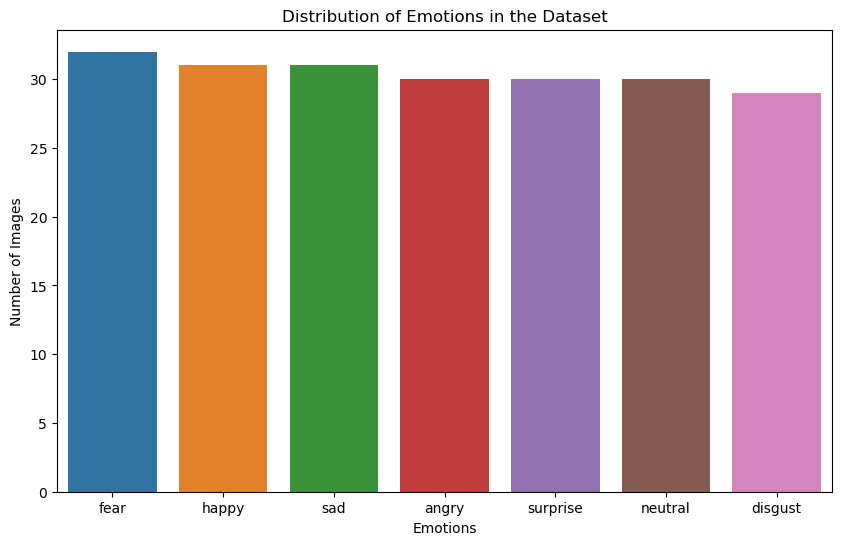

Found 170 validated image filenames belonging to 7 classes.
Found 43 validated image filenames belonging to 7 classes.


In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Define your dataset path
base_dir = 'jaffedbasee'  # Update this path

# Load all images and labels
image_paths = []
labels = []
emotions = ["happy", "angry", "surprise", "neutral", "sad", "disgust", "fear"]

for emotion in emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    for image_file in os.listdir(emotion_dir):
        if image_file.endswith('.tiff'):
            image_paths.append(os.path.join(emotion_dir, image_file))
            labels.append(emotion)

# Create a DataFrame
df = pd.DataFrame({'path': image_paths, 'label': labels})

# Split the data into train and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of images per class in the entire dataset
emotion_counts = df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.show()








# Data augmentation and generators
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(124, 124),
    color_mode="rgb",
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen_val.flow_from_dataframe(
    dataframe=validation_df,
    x_col='path',
    y_col='label',
    target_size=(124, 124),
    color_mode="rgb",
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG19 model
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(124, 124, 3))
conv_base.trainable = False  # Freeze the layers

# Build the model
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(emotions), activation='softmax'))  # 7 classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)




# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()




In [39]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG19 model
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(124, 124, 3))
conv_base.trainable = False  # Freeze the layers

# Build the model
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(emotions), activation='softmax'))  # 7 classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/5
2/2 [==============================] - 37s 12s/step - loss: 2.7318 - accuracy: 0.1698
Epoch 2/5
2/2 [==============================] - 26s 15s/step - loss: 1.7264 - accuracy: 0.4151
Epoch 3/5
2/2 [==============================] - 28s 18s/step - loss: 1.2642 - accuracy: 0.5755
Epoch 4/5
2/2 [==============================] - 25s 11s/step - loss: 0.8778 - accuracy: 0.6509
Epoch 5/5
2/2 [==============================] - 32s 15s/step - loss: 0.9574 - accuracy: 0.6484


KeyError: 'val_loss'

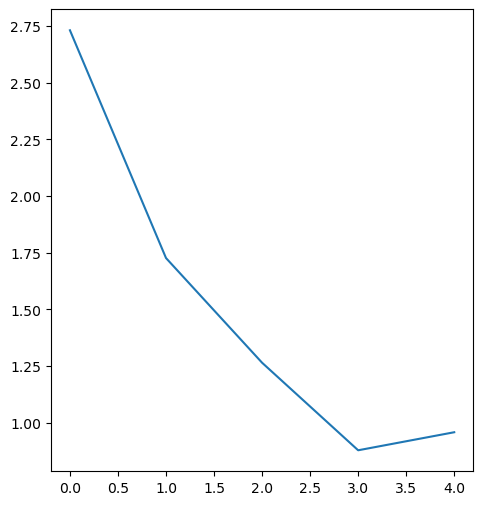

In [41]:

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


Epoch 1/5
2/2 [==============================] - 44s 25s/step - loss: 0.7422 - accuracy: 0.7578 - val_loss: 2.2995 - val_accuracy: 0.1860
Epoch 2/5
2/2 [==============================] - 42s 33s/step - loss: 0.7763 - accuracy: 0.7358 - val_loss: 2.3050 - val_accuracy: 0.1860
Epoch 3/5
2/2 [==============================] - 39s 24s/step - loss: 0.6499 - accuracy: 0.7422 - val_loss: 2.2889 - val_accuracy: 0.1395
Epoch 4/5
2/2 [==============================] - 33s 24s/step - loss: 0.5859 - accuracy: 0.7830 - val_loss: 2.3326 - val_accuracy: 0.2093
Epoch 5/5
2/2 [==============================] - 35s 19s/step - loss: 0.4399 - accuracy: 0.8585 - val_loss: 2.4301 - val_accuracy: 0.2093
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


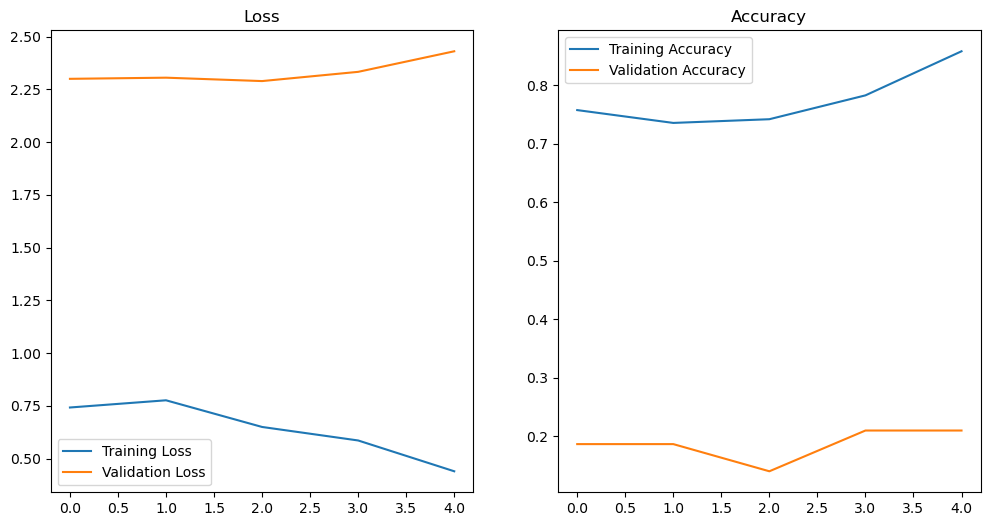

In [42]:
# ... [previous code]

# Train the model
epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size + 1  # Adjusted
)

# Debug: Print keys in history object
print(history.history.keys())

# Plot training history only if 'val_loss' key exists
if 'val_loss' in history.history:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Validation loss ('val_loss') not found in history. Check your validation data and steps.")


1/1 [==============================] - 11s 11s/step


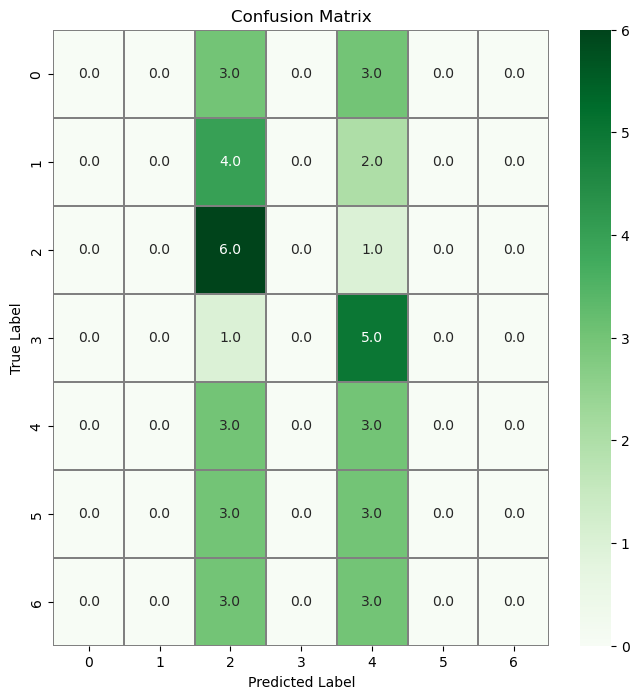

              precision    recall  f1-score   support

       happy       0.00      0.00      0.00         6
       angry       0.00      0.00      0.00         6
    surprise       0.26      0.86      0.40         7
     neutral       0.00      0.00      0.00         6
         sad       0.15      0.50      0.23         6
     disgust       0.00      0.00      0.00         6
        fear       0.00      0.00      0.00         6

    accuracy                           0.21        43
   macro avg       0.06      0.19      0.09        43
weighted avg       0.06      0.21      0.10        43



C:\Users\RAJESH KUMAR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAJESH KUMAR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAJESH KUMAR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the values from the validation dataset
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = validation_generator.classes

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print the precision and recall, among other metrics
print(classification_report(Y_true, Y_pred_classes, target_names=emotions))


In [ ]:
#split

In [48]:
import os
import random
from shutil import copy2

root_dir = 'jaffedbasee Copy'  # Change this to your dataset directory
class_subfolders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

train_ratio = 0.8

for class_subfolder in class_subfolders:
    class_dir = os.path.join(root_dir, class_subfolder)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.tiff') and os.path.isfile(os.path.join(class_dir, f))]
    
    # Shuffle the list of image files randomly
    random.shuffle(image_files)
    
    # Calculate the split point
    split_point = int(len(image_files) * train_ratio)
    train_files = image_files[:split_point]
    test_files = image_files[split_point:]
    
    # Create new folders for training and testing sets within each class subfolder
    train_dir = os.path.join(class_dir, 'train')
    test_dir = os.path.join(class_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Copy the appropriate percentage of images to the training and testing folders
    for file in train_files:
        src_file_path = os.path.join(class_dir, file)
        dest_file_path = os.path.join(train_dir, file)
        copy2(src_file_path, dest_file_path)
    
    for file in test_files:
        src_file_path = os.path.join(class_dir, file)
        dest_file_path = os.path.join(test_dir, file)
        copy2(src_file_path, dest_file_path)
    
    # Print some information for debugging
    print(f"Class: {class_subfolder}")
    print(f"Number of images in training set: {len(train_files)}")
    print(f"Number of images in testing set: {len(test_files)}")
    print(f"Train directory: {train_dir}")
    print(f"Test directory: {test_dir}")
    print("-----------------------------")


Class: angry
Number of images in training set: 24
Number of images in testing set: 6
Train directory: jaffedbasee Copy\angry\train
Test directory: jaffedbasee Copy\angry\test
-----------------------------
Class: disgust
Number of images in training set: 23
Number of images in testing set: 6
Train directory: jaffedbasee Copy\disgust\train
Test directory: jaffedbasee Copy\disgust\test
-----------------------------
Class: fear
Number of images in training set: 25
Number of images in testing set: 7
Train directory: jaffedbasee Copy\fear\train
Test directory: jaffedbasee Copy\fear\test
-----------------------------
Class: happy
Number of images in training set: 24
Number of images in testing set: 7
Train directory: jaffedbasee Copy\happy\train
Test directory: jaffedbasee Copy\happy\test
-----------------------------
Class: neutral
Number of images in training set: 24
Number of images in testing set: 6
Train directory: jaffedbasee Copy\neutral\train
Test directory: jaffedbasee Copy\neutral\t

In [49]:
import os
import random
from shutil import copy2

root_dir = 'jaffedbaseeCopy'  # Change this to your dataset directory
class_subfolders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

train_ratio = 0.8

# Create a new folder named 'dataset'
dataset_dir = 'jaFFFFFFdataset'
os.makedirs(dataset_dir, exist_ok=True)

for class_subfolder in class_subfolders:
    class_dir = os.path.join(root_dir, class_subfolder)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.tiff') and os.path.isfile(os.path.join(class_dir, f))]
    
    # Shuffle the list of image files randomly
    random.shuffle(image_files)
    
    # Calculate the split point
    split_point = int(len(image_files) * train_ratio)
    train_files = image_files[:split_point]
    test_files = image_files[split_point:]
    
    # Create new folders for training and testing sets within 'dataset' folder
    train_dir = os.path.join(dataset_dir, 'train', class_subfolder)
    test_dir = os.path.join(dataset_dir, 'test', class_subfolder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Copy the appropriate percentage of images to the training and testing folders
    for file in train_files:
        src_file_path = os.path.join(class_dir, file)
        dest_file_path = os.path.join(train_dir, file)
        copy2(src_file_path, dest_file_path)
    
    for file in test_files:
        src_file_path = os.path.join(class_dir, file)
        dest_file_path = os.path.join(test_dir, file)
        copy2(src_file_path, dest_file_path)
    
    # Print some information for debugging
    print(f"Class: {class_subfolder}")
    print(f"Number of images in training set: {len(train_files)}")
    print(f"Number of images in testing set: {len(test_files)}")
    print(f"Train directory: {train_dir}")
    print(f"Test directory: {test_dir}")
    print("-----------------------------")


Class: angry
Number of images in training set: 24
Number of images in testing set: 6
Train directory: jaFFFFFFdataset\train\angry
Test directory: jaFFFFFFdataset\test\angry
-----------------------------
Class: disgust
Number of images in training set: 23
Number of images in testing set: 6
Train directory: jaFFFFFFdataset\train\disgust
Test directory: jaFFFFFFdataset\test\disgust
-----------------------------
Class: fear
Number of images in training set: 25
Number of images in testing set: 7
Train directory: jaFFFFFFdataset\train\fear
Test directory: jaFFFFFFdataset\test\fear
-----------------------------
Class: happy
Number of images in training set: 24
Number of images in testing set: 7
Train directory: jaFFFFFFdataset\train\happy
Test directory: jaFFFFFFdataset\test\happy
-----------------------------
Class: neutral
Number of images in training set: 24
Number of images in testing set: 6
Train directory: jaFFFFFFdataset\train\neutral
Test directory: jaFFFFFFdataset\test\neutral
------